In [50]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")
figsize(7, 7)

Populating the interactive namespace from numpy and matplotlib


# PyTorch

"Tensors and Dynamic neural networks in Python with strong GPU acceleration"

- like Matlab or Numpy, but with GPU support
- automatic, dynamic differentiation and gradient descent
- some frameworks for neural networks

# SIMPLE COMPUTATIONS

In [86]:
# simple "tensors" (multidimensional numerical arrays) in Torch

import torch
data = torch.rand(256, 256)
print(data)

tensor([[0.5955, 0.6009, 0.1565,  ..., 0.1735, 0.9803, 0.4484],
        [0.6679, 0.2667, 0.1273,  ..., 0.0725, 0.8999, 0.9827],
        [0.0826, 0.7996, 0.4112,  ..., 0.5100, 0.4379, 0.5211],
        ...,
        [0.4063, 0.9109, 0.3149,  ..., 0.6115, 0.3473, 0.9782],
        [0.9079, 0.3287, 0.2481,  ..., 0.6348, 0.4507, 0.0289],
        [0.5737, 0.8372, 0.7232,  ..., 0.6465, 0.2382, 0.4439]])


In [87]:
# a pointless GPU computation

if torch.has_cuda:
    data = torch.rand(256, 256).cuda()
    out = data
    for i in range(100):
        out = torch.mm(data, out)
        out /= out.norm()
    imshow(out.cpu().numpy())
else:
    print("CUDA not available")

CUDA not available


# PyTorch 

- standard set of numerical operations
- similar primitives to Numpy, Matlab
- operations run on CPU and GPU
- GPU operations use CUDA, cuDNN, some third party kernels
- direct binding: you call a numerical function, it calls the kernel

# AUTOMATIC DIFFERENTIATION

In [88]:
def tshow(image, **kw):
    if image.ndimension()==2:
        imshow(image.detach().cpu().numpy(), **kw)
    elif image.ndimension()==3:
        if image.shape[0]==1:
            tshow(image[0])
        else:
            imshow(image.detach().cpu().permute(1, 2, 0).numpy(), **kw)
    elif image.ndimension()==4:
        tshow(image[0])

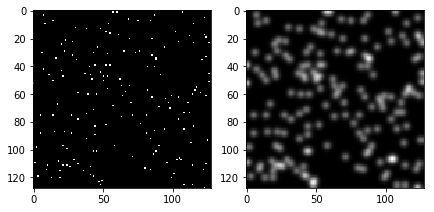

In [107]:
def generate_pair():
    image = (torch.rand((128, 128)) > 0.99).type(torch.float)
    import scipy.ndimage as ndi
    target = torch.tensor(ndi.gaussian_filter(image.numpy(), 2.0))
    return image, target

image, target = generate_pair()
subplot(121); tshow(image); subplot(122); tshow(target)

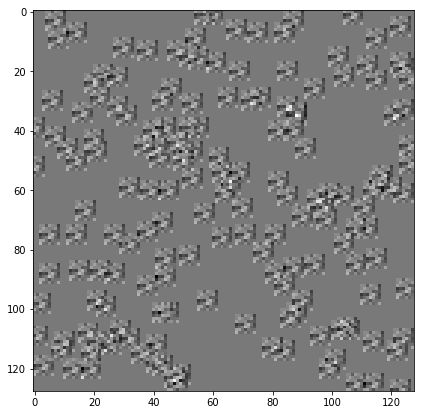

In [108]:
#### 2D Convolutions

import torch.nn.functional as F

x = image[None, None, :, :]
y = target[None, None, :, :]

w = torch.randn(1, 1, 7, 7)
w.requires_grad = True
b = torch.rand(1)
b.requires_grad = True

y_predicted = F.conv2d(x, w, padding=3) + b[None, :, None, None]

tshow(y_predicted)

In [109]:
w

tensor([[[[ 1.3827, -0.0875, -0.6162,  0.5861, -0.4267, -0.2610,  1.8307],
          [-0.2766, -0.3674, -0.0382, -1.3516, -0.2007,  1.3252,  1.3670],
          [-1.2168, -0.7726,  1.0208,  2.0471,  0.2574, -0.3855, -1.1739],
          [-1.6076, -0.0821,  1.7794,  0.8683, -1.7173, -1.3402, -2.0731],
          [-0.9897, -0.8137, -1.0424,  0.5743,  0.4610,  0.4795,  1.2777],
          [-1.3044,  0.8928,  0.2562,  0.0560,  0.5057,  1.2756,  0.3679],
          [-1.8096,  0.2064,  0.4816,  1.0225, -0.8690,  0.5513,  0.5510]]]],
       requires_grad=True)

In [110]:
w.grad

In [111]:
# Computing the Error

err = ((y_predicted - y)**2).sum()
print(err)

err.backward(retain_graph=True)
print(w.grad)
print(b.grad)

tensor(11677.2891, grad_fn=<SumBackward0>)
tensor([[[[ 612.3992,  110.1348,  -61.8006,  344.4505,    5.2245,   58.7420,
            721.2454],
          [  66.2165,   26.7947,  132.1782, -316.9474,   84.4333,  592.0923,
            568.0762],
          [-234.4124, -129.7010,  477.7744,  801.4025,  231.4945,   23.2410,
           -247.0241],
          [-368.0635,  115.8301,  720.1642,  415.0942, -429.5951, -276.8540,
           -541.8770],
          [-154.3808, -108.2697, -223.6758,  353.2870,  300.2126,  280.5952,
            548.3215],
          [-256.8300,  447.0406,  236.1110,  160.2641,  296.1224,  552.9665,
            260.1417],
          [-403.4394,  211.6137,  302.4915,  450.7604, -162.0916,  322.1156,
            334.5525]]]])
tensor([14639.2783])


In [112]:
from graphviz import Digraph
def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='9',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12", rankdir="LR"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

{140396982731112: 'w', 140396981230328: 'x', 140396980377568: 'b'}


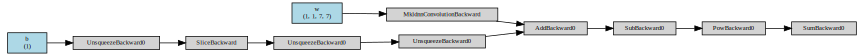

In [113]:
make_dot(err, dict(w=w, x=x, b=b))

# PyTorch Autograd Summary

- Tensors $\rightarrow$ Variables
- PyTorch keeps track of derivatives
- computation graphs can be completely dynamic
- propagate derivatives backwards using `x.backward()`
- access gradients using `x.grad`

# SIMPLE LEARNING

In [115]:
for i in range(5000):
    
    optimizer = optim.SGD([w, b], lr=1e-5)
    optimizer.zero_grad()
    
    y_predicted = F.conv2d(x, w, padding=3)
    
    err = ((y_predicted - y)**2).sum()
    err.backward()
    if i%1000==0: print(f"{i:6d} {err:.3f}")
    
    optimizer.step()

     0 0.144
  1000 0.143
  2000 0.143
  3000 0.143
  4000 0.143


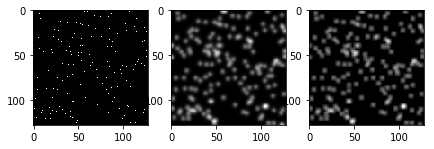

In [116]:
subplot(131); tshow(x); subplot(132); tshow(y); subplot(133); tshow(y_predicted)

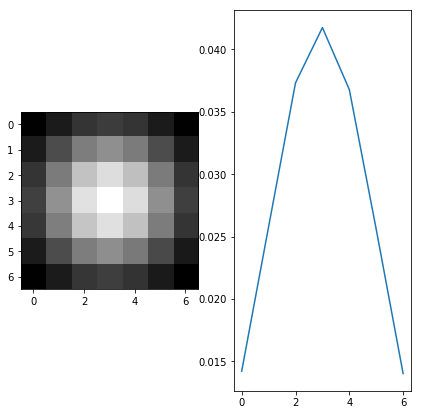

In [119]:
subplot(121); tshow(w); subplot(122); plot(w[0, 0, 3, :].detach().numpy())

# Learning a Linear Filter with Layers

- above example used gradient descent using completely functional computations
- a `Conv2d` layer is the same as a linear filter
- let's see whether we can learn this using PyTorch
- this uses all the components we need to train more complex models in PyTorch

In [122]:
from torch import nn, optim

# the "model" is just a single convolutional layer
model = nn.Conv2d(1, 1, (17, 17), padding=8)

# the loss is MSE loss
criterion = nn.MSELoss()

In [126]:
x, y = generate_pair()

for i in range(5000):
    
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()
    
    y_predicted = model(x[None, None, :, :])
    
    loss = criterion(y[None, None, :, :], y_predicted)
    if i%500==0: print(i, loss.item())
    loss.backward()
    
    optimizer.step()

0 6.946246139705181e-05
500 1.3632376067107543e-05
1000 4.894945050182287e-06
1500 3.417339257794083e-06
2000 3.14949784296914e-06
2500 3.0978999348008074e-06
3000 3.0874205094733043e-06
3500 3.0851942938170396e-06
4000 3.0847022571833804e-06
4500 3.0845899345877115e-06


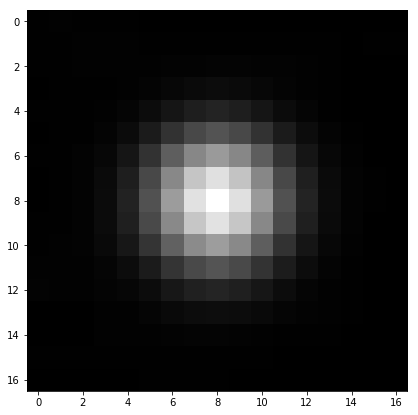

In [127]:
# display the learned kernel
imshow(list(model.parameters())[0].data[0,0].cpu().numpy())

# Torch "Modules" / "Layers"

In [128]:
import torch.functional as F

class Linear(nn.Module):
    def __init__(self, ninput, noutput):
        self.weights = Parameter(torch.randn(noutput, ninput))
    def forward(self, x):
        return F.linear(x, self.weights)
    # NB: no "backward" method needed

# Composition of Torch Layers

In [129]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)  
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# Summary of Torch "Modules" and Training

- training uses modules, criteria, and optimizers
- modules (nn.Module) keep track of parameters and compute in the forward method
- criteria compute the differences between two outputs and return a scalar loss
- optimizers initiate gradient computation and then update the model parameters

# PYTORCH VS OTHERS

# Common Deep Learning Frameworks

Primary:

- TensorFlow
- PyTorch (old: Torch)
- Caffe 2 (old: Caffe)
- mxnet
- Chainer

Derived:

- Keras
- Theano

# TensorFlow

- superficially like PyTorch, but internally very different
- core is a dataflow language, completely separate from Python

Issues:
- tons of code between you and the kernels
- many custom written Google kernels
- memory hungry
- RNN support is worse

# PyTorch

Issues:

- Python multithreading is poor, therefore...
- limited ability to write high performance multi-GPU code

Potential Solutions:
- port to IronPython (C#, .NET)
- future, better Python JIT/compilers

# Future?

- both PyTorch and Tensorflow have serious limitations
- either they will substantially, or new frameworks will come around